In [1]:
"""
Allow some options on the plots (zoom, resize, save),
/!\: have to wait to the end of the cell's execution
before launch the next
"""
# %matplotlib notebook

# standard plot inside the netbook, but no options available
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

import birdsonganalysis as bsa

# utils module from current folder
from utils import (boari_synth_song_error, draw_learning_curve,
                   carac_to_calculate_err_of_synth, err_per_feat)
from cmp_2_sim import plot_gesture_starts

# Allow to import the modules in the model folder
sys.path.append('../model/')
from measures import normalize_and_center, bsa_measure
from song_fitter import SongModel, get_scores
from synth import synthesize

sns.set_palette('colorblind')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 5

In [2]:
# path of the folder with the results
path = '../model/res/'
path += 'rescal_meas_512_180628_105239/'

# seed = "seed0"
# nlm = "mutate_best_models_elite"
# # nlm = "mutate_microbial_diversity_uniform"
# conf_name = "rescal_meas_512"
# coef = "1en_1amp"
# params = [seed, nlm, conf_name, coef]
# path += '+'.join(params)

path += "seed0+mutate_best_models_elite+rescal_meas_512+1en_1amp"

# tmp: pour check l'avancée des simu du cluster
# path = '../model/res/'
# path += 'optimise_gesture_whole_local_search+mutate_microbial_diversity_uniform+rescal_meas_fast_neg_beta_zero+default_coef'

if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

In [3]:
# load the parameters used for the simulation
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
    
try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    print('No desc for this run.')

No desc for this run.


# Simulation parameters

In [4]:
out = '| key | value |\n|---|---|\n' + '\n'.join(['| {} | {} |'.format(key, run_param[key]) for key in sorted(run_param.keys())])
display(Markdown(out))

| key | value |
|---|---|
| coefs | {'entropy': 1, 'amplitude': 1, 'goodness': 0, 'pitch': 0, 'fm': 0, 'am': 0} |
| comp | linalg |
| concurrent | 3 |
| days | 25 |
| decay | linear |
| dev | [0.1, 0.1, 0.05, 1, 0.05, 0.05, 0.05, 1, 0.001, 0.001, 0.005, 100, 0.2, 0.05, 0.01, 0.05, 1, 0.005] |
| diversity_threshold | 500 |
| dlm | optimise_gesture_whole_local_search |
| iter_per_train | 20 |
| maxs | [50, 4, 3.141592653589793, 40000, 50, 4, 3.141592653589793, 40000, 50, 5, 3.141592653589793, 40000, 10, 50, 3, 3.141592653589793, 1000, 0] |
| mins | [-50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -5, -50, 0, -3.141592653589793, 0, -3] |
| name | seed0+mutate_best_models_elite+rescal_meas_512+1en_1amp |
| night_concurrent | 50 |
| nlm | mutate_best_models_elite |
| prior | [0, 0, 3.141592653589793, 15, 0, 0, 0.39269908169872414, 45, 0, 0, 0, 5000, 0, 0, 0, 0, 0, -0.15] |
| replay | 200 |
| seed | 0 |
| train_per_day | 200 |
| tutor | ../data/boari_short.wav |

# Get data

In [5]:
# -- Tutor --
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
tutor = normalize_and_center(tutor)

# -- Song learned --
outputs = []

try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    try:
        warnings.warn('Learning not over')
        with open(join(path, 'data_cur.pkl'), 'rb') as f:
            songlog = pickle.load(f)
    except FileNotFoundError:
        print("Error: no data files")
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)
best = np.argmin(rd['scores'].iloc[-1])
smodels = rd['songs'].iloc[-1]
ab = smodels[best].gen_alphabeta()
song = smodels[best].gen_sound()
g_starts = []
for i, gesture in enumerate(smodels[best].gestures):
            g_starts.append(gesture[0])

# outputs contains the different final songs
outputs = [smodel.gen_sound() for smodel in smodels]

# Allow to split the gesture on the alpha and beta plots
for start, g in smodels[best].gestures:
    ab[start] = np.nan

# -- Boari's Synthesized song --
song_name = basename(run_param['tutor']).split('.')[0]
sr, synth_song = wavfile.read('../data/{}_out.wav'.format(song_name))
synth_ab = np.loadtxt('../data/{}_ab.dat'.format(song_name))
"""
add the missing samples to synth_ab because
The Boari's algorithm to generate synthesized song removes 612 samples
"""
pad0 = synth_ab[-1,0] * np.ones((612,1))
pad1 = synth_ab[-1,1] * np.ones((612,1))
pad = np.concatenate((pad0, pad1), axis=1)
synth_ab = np.concatenate((synth_ab, pad), axis=0)

In [6]:
# tmp: pour check l'avancée des simu du cluster
# rd

# Sound waves and spectral derivatives

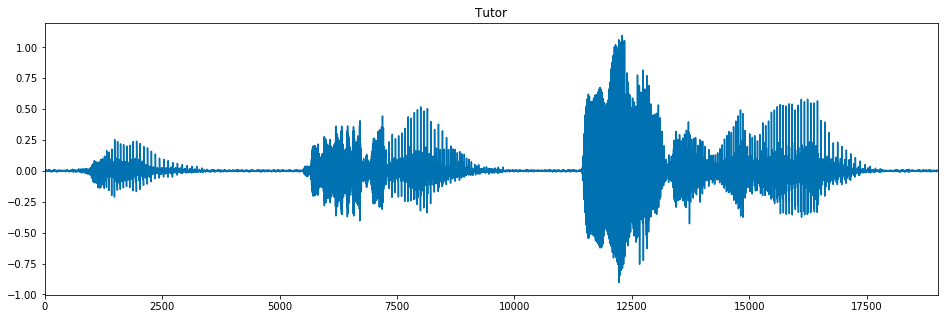

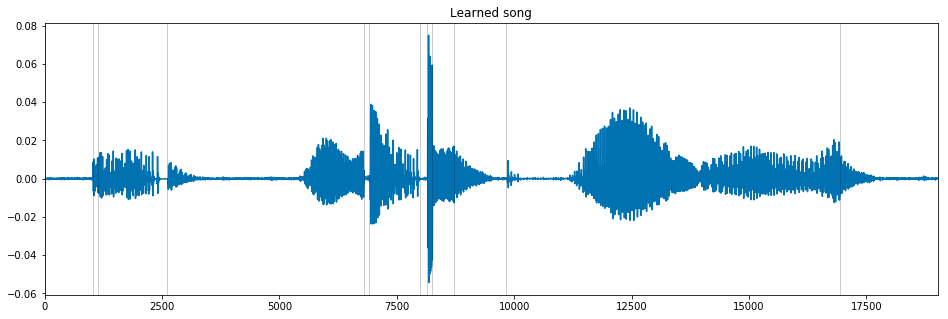

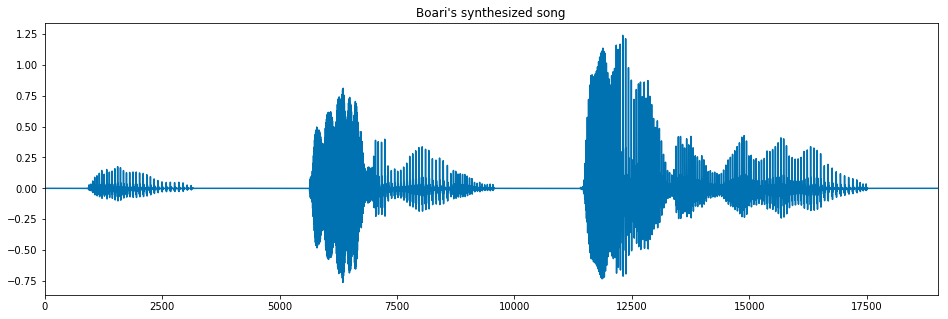

In [7]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(tutor)
plt.xlim(0,len(tutor))
plt.title("Tutor")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(song)
plt.xlim(0,len(song))
plot_gesture_starts(g_starts)
plt.title("Learned song")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_song)
plt.xlim(0,len(synth_song))
plt.title("Boari's synthesized song")
plt.show()

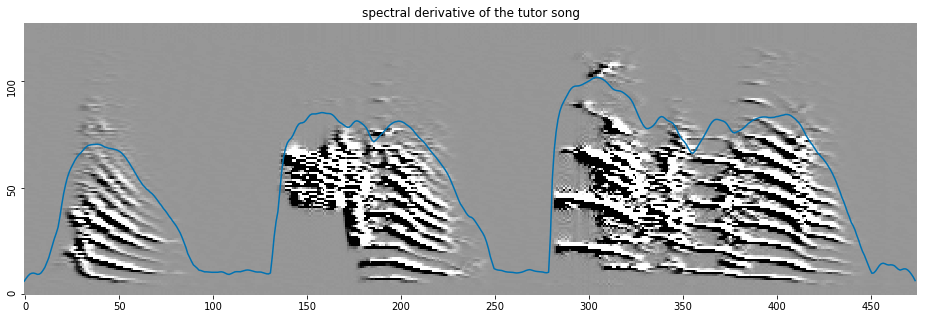

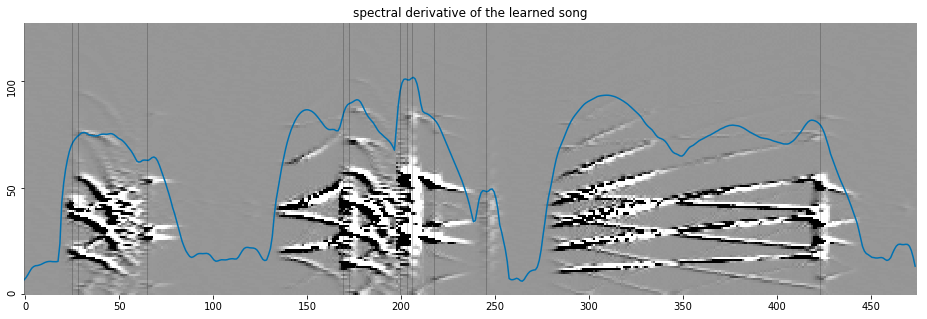

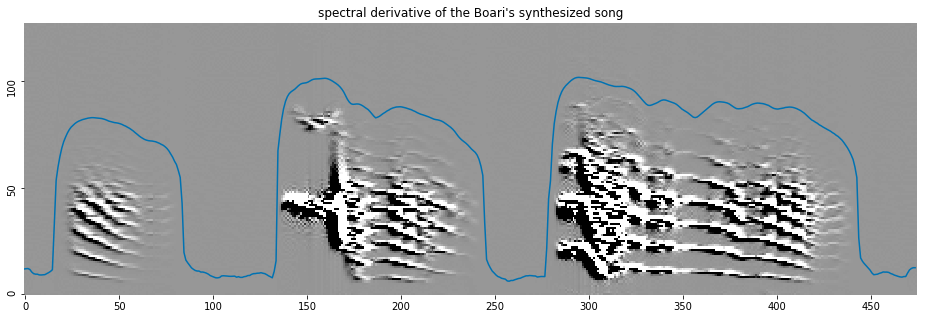

In [8]:
zoom = bsa.FFT_SIZE / bsa.FREQ_RANGE / 4

tutor_spec = bsa.spectral_derivs(tutor,
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
song_spec = bsa.spectral_derivs(song, 
                                bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
synth_spec = bsa.spectral_derivs(synth_song, 
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)

# Spectral derivative of the tutor song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(tutor_spec, contrast=0.01, ax=ax,
                         freq_range=bsa.FREQ_RANGE)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

# Spectral derivative of the learned song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(song_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song,
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plot_gesture_starts(g_starts, scale=bsa.FFT_STEP)
plt.title("spectral derivative of the learned song")
plt.show(fig)

# Spectral derivative of the Boari's synthesized song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(synth_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth_song,
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the Boari's synthesized song")
plt.show(fig)

# Sound

In [9]:
# Sound of the tutor song
display(Audio(tutor, rate=bsa.SR))

In [10]:
# Audio of the final songs
for output in outputs:
    display(Audio(output, rate=bsa.SR))

In [11]:
# Audio of the Boari's synth song
display(Audio(synth_song, rate=bsa.SR))

# Get features

In [12]:
# -- Tutor features --
tfeat= bsa.all_song_features(tutor, bsa.SR,
                             freq_range=bsa.FREQ_RANGE,
                             fft_step=bsa.FFT_STEP,
                             fft_size=bsa.FFT_SIZE)

tutor_feat = bsa.rescaling_with_tutor_values(tfeat, tfeat)

# -- Learned song features --
sfeat = bsa.all_song_features(song, bsa.SR, freq_range=bsa.FREQ_RANGE,
                              fft_size=bsa.FFT_SIZE, fft_step=bsa.FFT_STEP)
song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# -- Boari's synth song features --
syfeat = bsa.all_song_features(synth_song, bsa.SR, freq_range=bsa.FREQ_RANGE,
                              fft_size=bsa.FFT_SIZE, fft_step=bsa.FFT_STEP)
synth_feat = bsa.rescaling_with_tutor_values(tfeat, syfeat)

# Features comparison

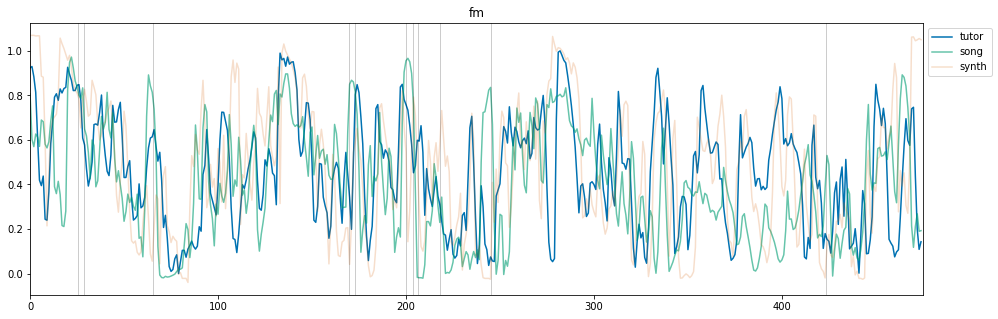

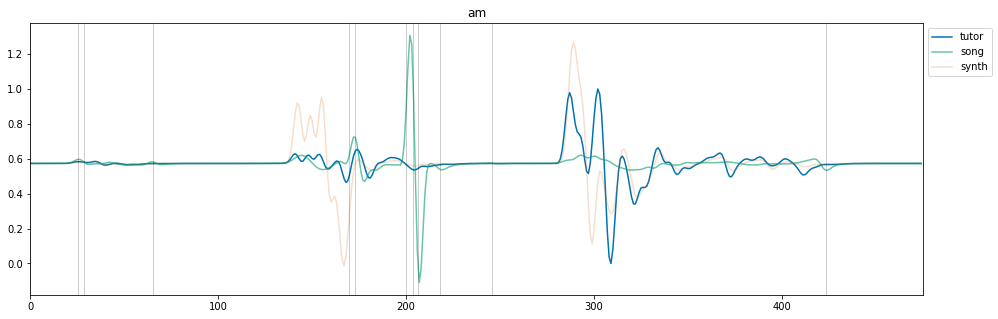

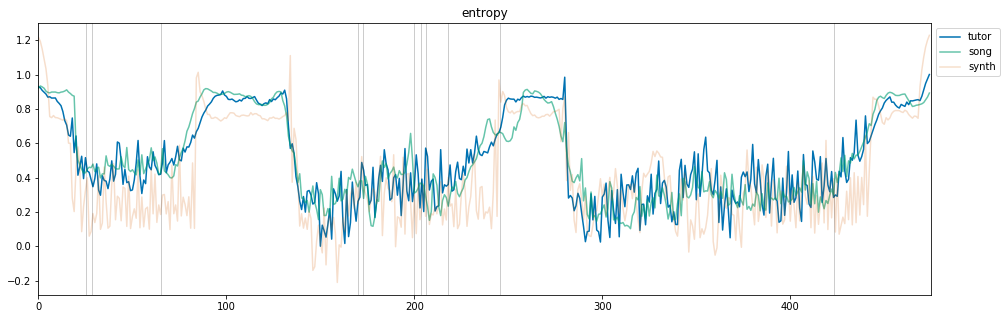

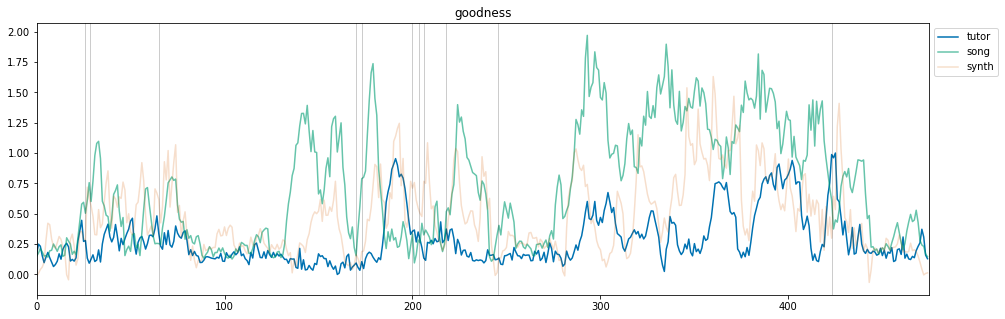

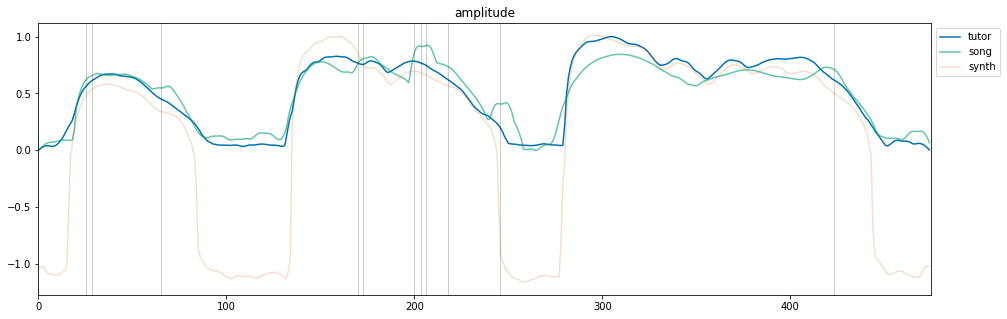

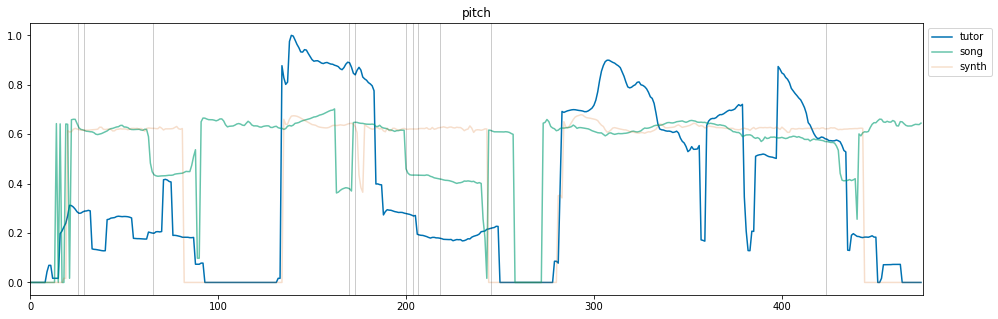

In [13]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude', 'pitch']
for fname in fnames:
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(tutor_feat[fname], label="tutor")
    plt.plot(song_feat[fname], alpha=0.6, label="song")
    plt.plot(synth_feat[fname], alpha=0.2, label="synth")
    plot_gesture_starts(g_starts, scale=40)
    plt.xlim(0, len(tutor_feat[fname]))
    plt.legend()
    plt.title(fname)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

# Learning curve

coefficients: {'entropy': 1, 'amplitude': 1, 'goodness': 0, 'pitch': 0, 'fm': 0, 'am': 0}
Boari's score on boari_short.wav : 8.197813525301262
Best song model score: 3.543133791379823


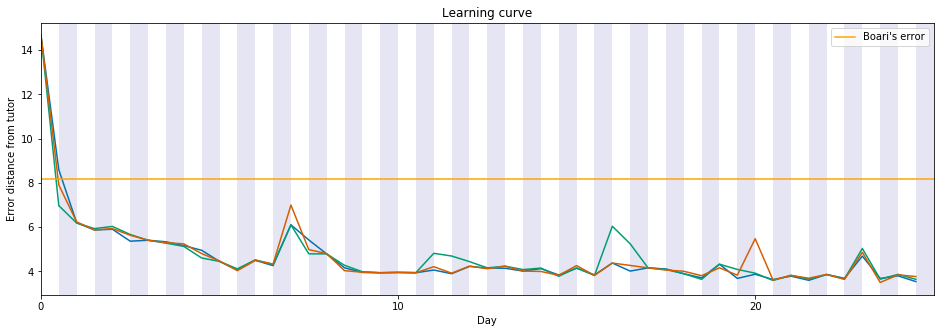

In [14]:
# /!\: if tutor_feat parameter is defined,
# use rescaling to calculate the error
score = boari_synth_song_error(tutor,
                               synth_song,
                               run_param['coefs'],
                               tutor_feat=tfeat)

best_score = rd['scores'].iloc[-1][best]
print("coefficients: {}".format(run_param['coefs']))
print("Boari's score on {}.wav : {}".format(song_name, score))
print("Best song model score: {}".format(best_score))

# Plot
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
ax = draw_learning_curve(rd, ax=ax)
ax.axhline(y=score, color='orange', linestyle='-',
           label="Boari's error")
ax.legend()
plt.show(fig)

In [15]:
print("first scores: {}".format(rd['scores'].iloc[0]))
print("last scores: {}".format(rd['scores'].iloc[-1]))
print("the best song index: {}".format(best))

first scores: [14.6666737 14.6666737 14.6666737]
last scores: [3.54313379 3.64613527 3.77186423]
the best song index: 0


# Gesture analysis

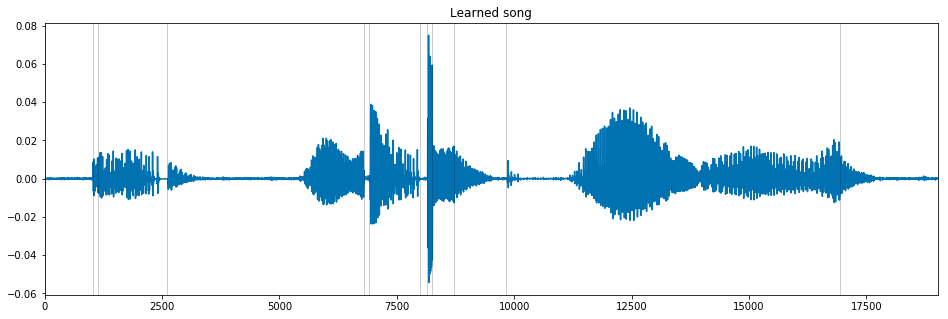

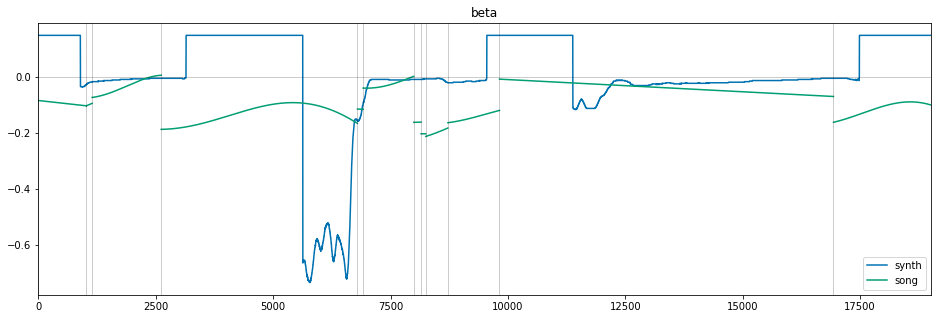

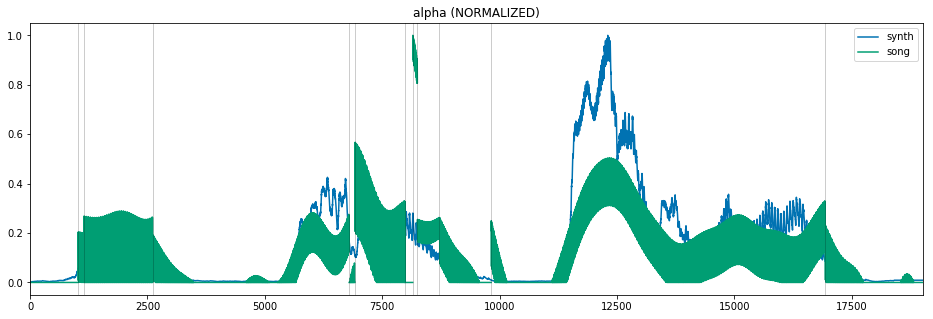

In [16]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(song)
plt.xlim(0, len(song))
plot_gesture_starts(g_starts)
plt.title("Learned song")
plt.show()

# Comparison between learnt beta and tutor's beta
plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_ab[:, 1], label="synth")
plt.plot(ab[:, 1], label="song")
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2)
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)
plt.legend()
plt.title("beta")

# Normalization for easier comparison between learnt alpha and tutor's alpha
a_t = (synth_ab[:, 0] - np.min(synth_ab[:, 0])) / (np.max(synth_ab[:, 0]) - np.min(synth_ab[:, 0]))
a_s = (ab[:,0] - np.nanmin(ab[:,0])) / (np.nanmax(ab[:,0]) - np.nanmin(ab[:,0]))

plt.figure(figsize=(fig_width, fig_height))
plt.title("alpha (NORMALIZED)")
plt.plot(a_t, label="synth")
plt.plot(a_s, label="song")
# plt.plot(synth_ab[:, 0], alpha=0.3, label="synth")
# plt.plot(ab[:,0], alpha=0.7, label="song")
plt.legend()
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)

In [17]:
# number of gestures in a learnt song
len(smodels[best].gestures)

12

In [18]:
# numbers of gtes in the tutor song
gtes = np.loadtxt('../data/{}_gte.dat'.format(song_name))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]
len(true_gtes)

20

# Alpha - Beta of songs

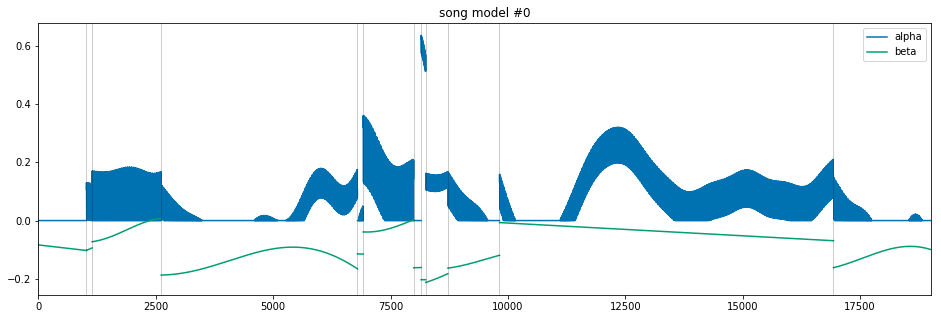

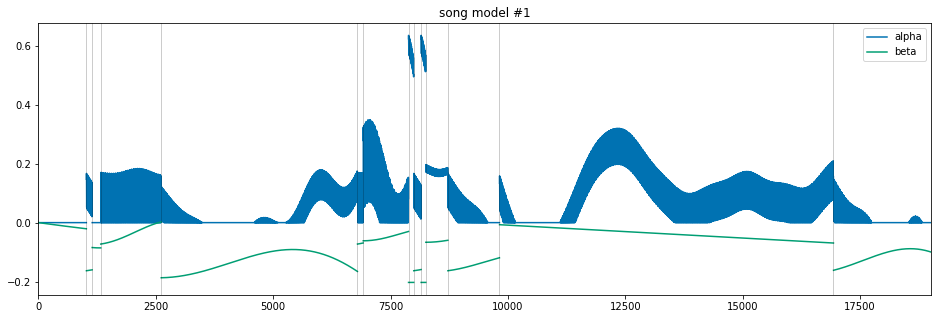

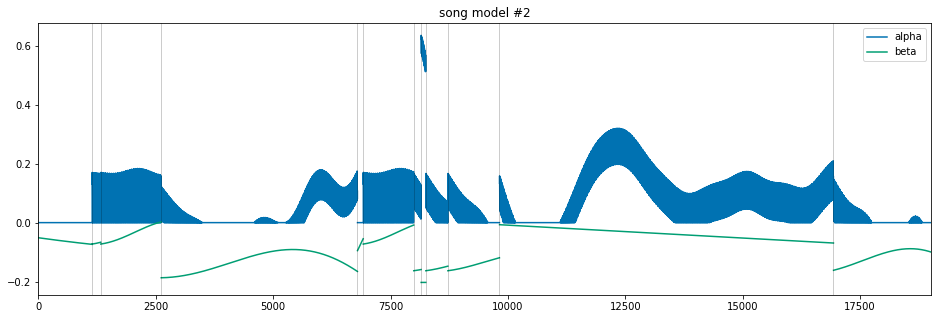

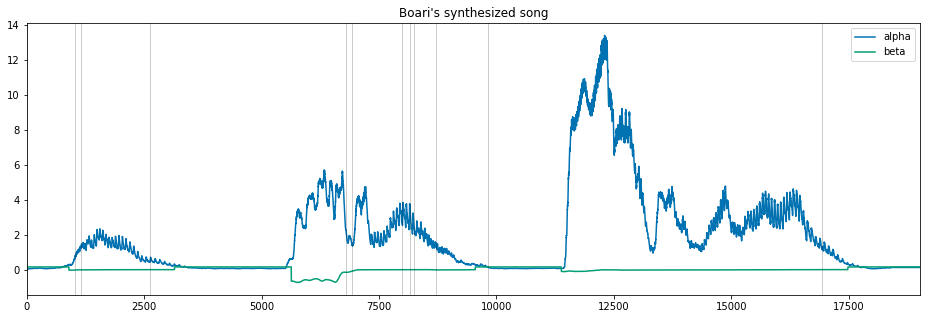

In [19]:
# plot the (alpha, beta) for the final songs and 
# the (alpha, beta) of the tutor's song with the GTEs
for i in range(len(rd['songs'].iloc[-1])):
    plt.figure(figsize=(fig_width, fig_height))
    ab_tmp = rd['songs'].iloc[-1][i].gen_alphabeta()
    # Allow to split the gesture on the alpha and beta plots
    for start, g in smodels[i].gestures:
        ab_tmp[start] = np.nan
    plt.plot(ab_tmp[:, 0], label="alpha")
    plt.plot(ab_tmp[:, 1], label="beta")
    plt.xlim((0, ab_tmp.shape[0]))
    #plt.yticks([], [])
    for gesture in rd['songs'].iloc[-1][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
    plt.title("song model #{}".format(i))
    plt.legend()

# Tutor song + gtes of the best optimised song
plt.figure(figsize=(fig_width,fig_height))
plt.plot(synth_ab[:,0], label="alpha")
plt.plot(synth_ab[:,1], label="beta")
plt.xlim((0, ab.shape[0]))
for gesture in rd['songs'].iloc[-1][best].gestures:
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.title("Boari's synthesized song")
plt.legend()
plt.show()

# Calculation of each feature's error

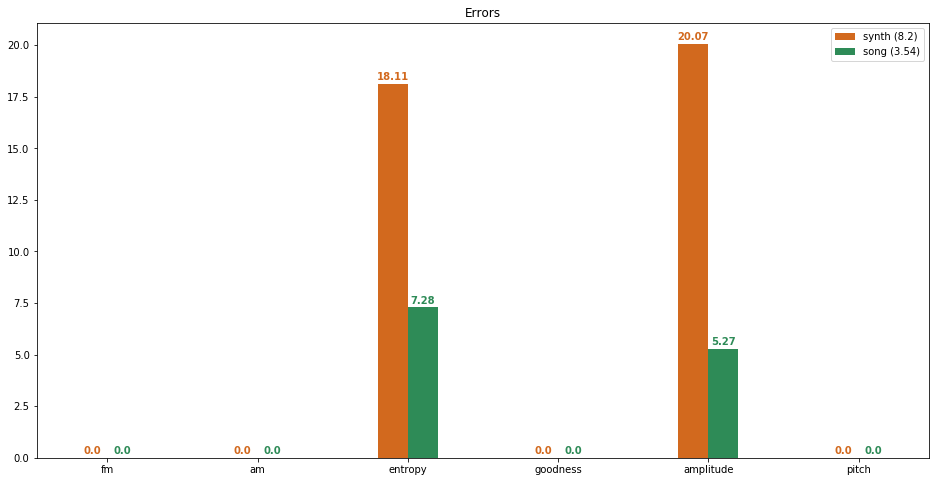

In [20]:
# Code inspired from cmp_2_sim.py
color_synth = "chocolate"
color_song = "seagreen"
    
amp, th = carac_to_calculate_err_of_synth(synth_song,
                                          tutor_feat["amplitude"])

mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

err_feat_vect = err_per_feat(mtutor, msong)
err_feat_vect_synth = err_per_feat(mtutor[amp > th],
                                   msynth[amp > th])

x = np.arange(0,len(err_feat_vect))
fig = plt.figure(figsize=(fig_width,8))
ax = fig.gca()
synth_score = round(score, 2)
song_score = round(best_score, 2)
synth_label = "synth ({})".format(synth_score)
song_label = "song ({})".format(song_score)
plt.bar(x - 0.1, err_feat_vect_synth,
        width=0.2, align='center',
        label=synth_label, color=color_synth)
plt.bar(x + 0.1, err_feat_vect,
        width=0.2, align='center',
        label=song_label, color=color_song)
plt.xticks(x, fnames)
shift = np.max(np.concatenate((err_feat_vect_synth,
                               err_feat_vect))) / 100
for index in x:
    v_synth = err_feat_vect_synth[index]
    v_song = err_feat_vect[index]
    ax.text(index - 0.1, v_synth + shift,
            str(round(v_synth, 2)),
            color=color_synth, ha="center", fontweight='bold')
    ax.text(index + 0.1, v_song + shift,
            str(round(v_song, 2)),
            color=color_song, ha="center", fontweight='bold')
plt.legend()
plt.title("Errors")
plt.show()